952


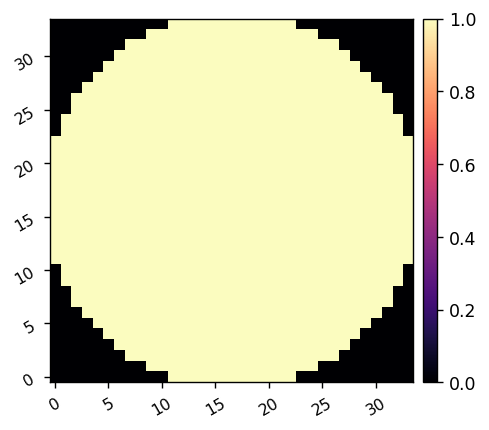

In [1]:

import numpy as np
import astropy.units as u
from astropy.io import fits

import scoobpsf
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

from importlib import reload

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from scipy.optimize import minimize

npix = 500
Nact = 34
wavelength = 650e-9*u.m
pupil_diam = 9.4*u.mm

dm_mask = xp.ones((Nact,Nact), dtype=bool)
xx = (xp.linspace(-Nact//2, Nact//2 - 1, Nact) + 1/2)
x,y = xp.meshgrid(xx,xx)
r = xp.sqrt(x**2 + y**2)
dm_mask[r>(Nact/2 + 1/2)] = 0
Nacts = int(xp.sum(dm_mask))
print(Nacts)
imshow1(dm_mask)

15.957446808510637
574


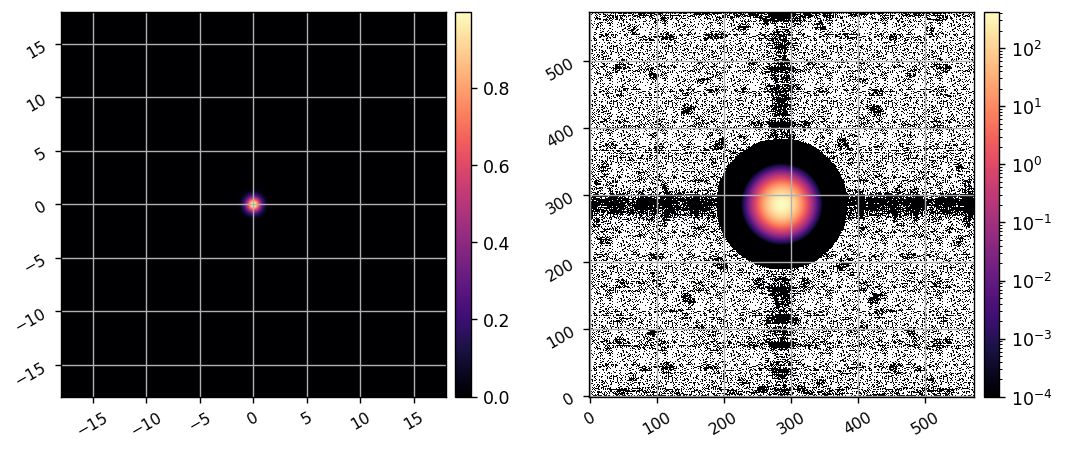

In [20]:
act_spacing = 0.3*u.mm
inf_sampling = (npix/pupil_diam * act_spacing).value
print(inf_sampling)

# Nsurf = int(2 ** np.ceil(np.log2(inf_sampling*Nact - 1)))  # next power of 2
# print(Nsurf)

reload(ad_scoob)
inf_fun = ad_scoob.make_gaussian_inf_fun(act_spacing=act_spacing, sampling=inf_sampling, 
                                         Nacts_per_inf=Nact + 2, # number of influence functions across the grid
                                         coupling=0.15,)

Nsurf = inf_fun.shape[0]
print(Nsurf)

fourier_inf_fun = xp.fft.fft2(inf_fun)
imshow2(inf_fun, xp.abs(xp.fft.fftshift(fourier_inf_fun)), pxscl1=1/inf_sampling, grid=True, lognorm2=True, vmin2=1e-4)

# DM command coordinates
xc = inf_sampling*(xp.linspace(-Nact//2, Nact//2-1, Nact) + 1/2)
yc = inf_sampling*(xp.linspace(-Nact//2, Nact//2-1, Nact) + 1/2)
    
# Influence function frequncy sampling
fx = xp.fft.fftfreq(Nsurf)
fy = xp.fft.fftfreq(Nsurf)

# forward DM model MFT matrices
Mx = xp.exp(-1j*2*np.pi*xp.outer(fx,xc))
My = xp.exp(-1j*2*np.pi*xp.outer(yc,fy))

Mx_back = xp.exp(-1j*2*np.pi*xp.outer(xc,fx))
My_back = xp.exp(-1j*2*np.pi*xp.outer(fy,yc))


Oversampling > 2x suggested for reliable results in Fresnel propagation.


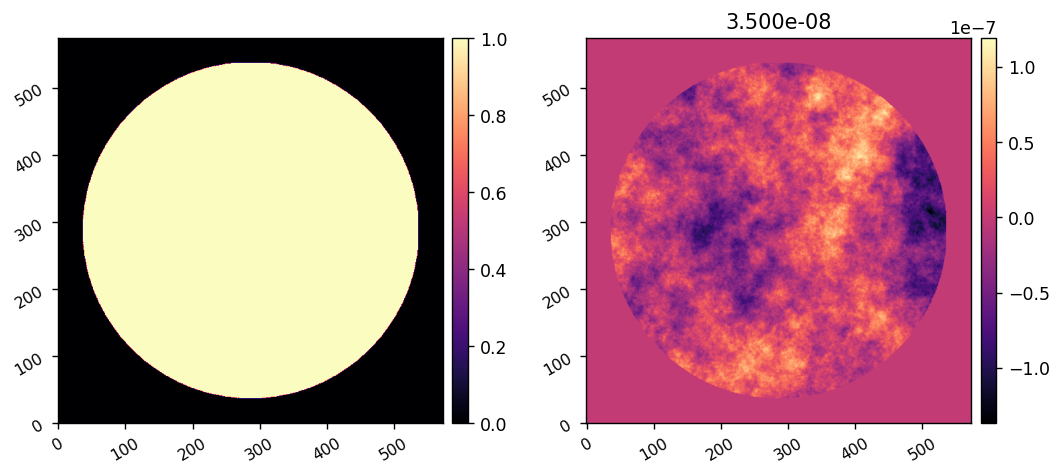

In [33]:
reload(utils)
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

mask = utils.pad_or_crop(mask, Nsurf)
WFE = utils.pad_or_crop(WFE, Nsurf)

wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(mask, wfe_opd,  '', f'{rms_opd:.3e}')

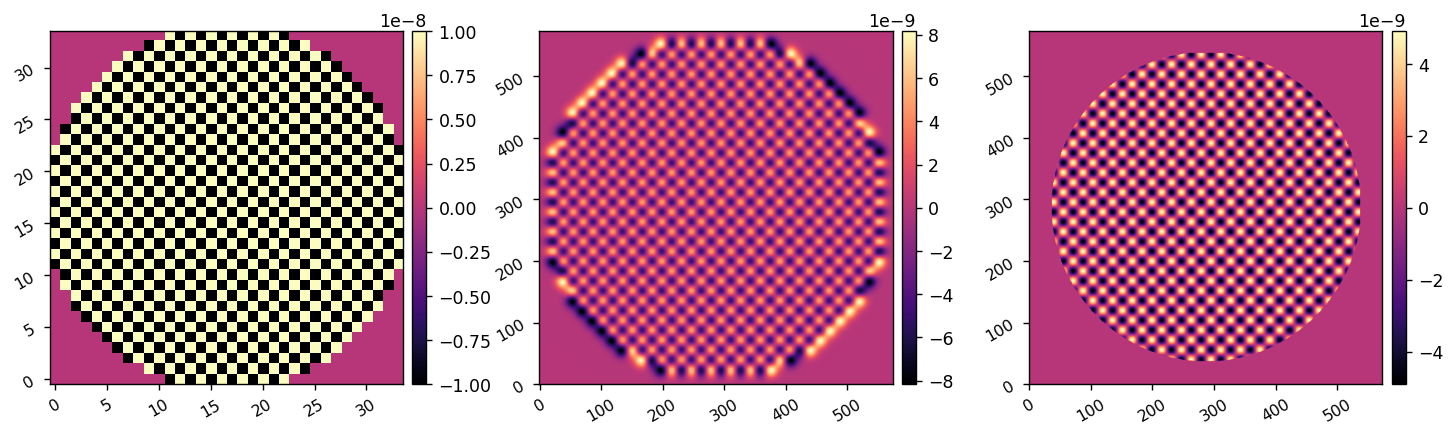

In [53]:
def forward_dm(command):
    mft_command = Mx@command@My
    fourier_surf = fourier_inf_fun * mft_command
    surf = xp.fft.ifft2(fourier_surf).real
    return surf

waffle_command = 10e-9 * xp.ones((Nact,Nact))
waffle_command[1::2, ::2] *= -1
waffle_command[::2, 1::2] *= -1
# waffle_command[1::2, 1::2] = 0
waffle_command *= dm_mask
waffle_surf = forward_dm(waffle_command)
imshow3(waffle_command, waffle_surf, waffle_surf*mask)

In [13]:
fourier_inf_fun[20,40], fourier_inf_fun.transpose().conjugate()[40,20]

(array(0.12845324+0.04376741j), array(0.12845324-0.04376741j))

In [35]:
def adjoint_dm(dJ_dsDM):
    """
    The input is the gradient of a cost-function with respect to 
    the DM surface.

    This function back propagates this gradient to compute the gradient 
    with respect to the DM actuators. 
    """

    x2_bar = xp.fft.fft2(dJ_dsDM)
    x1_bar = fourier_inf_fun.transpose().conjugate() * x2_bar
    # print(Mx.shape, x1_bar.shape)
    dJ_dA = Mx_back@x1_bar@My_back

    return ensure_np_array(dJ_dA)

In [36]:
xp.sum(dJ_dA.real), xp.sum(dJ_dA.imag)

(1081.9062535527207, 2.060510606874741e-15)

1081.9062535527207 2.060510606874741e-15


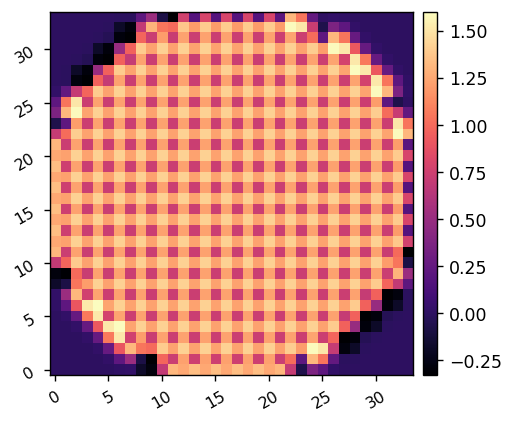

In [37]:
dJ_dsDM = xp.zeros((Nsurf,Nsurf))
dJ_dsDM = 2*waffle_surf
dJ_dA = adjoint_dm(dJ_dsDM)
print(xp.sum(dJ_dA.real), xp.sum(dJ_dA.imag))
imshow1(dJ_dA.real)

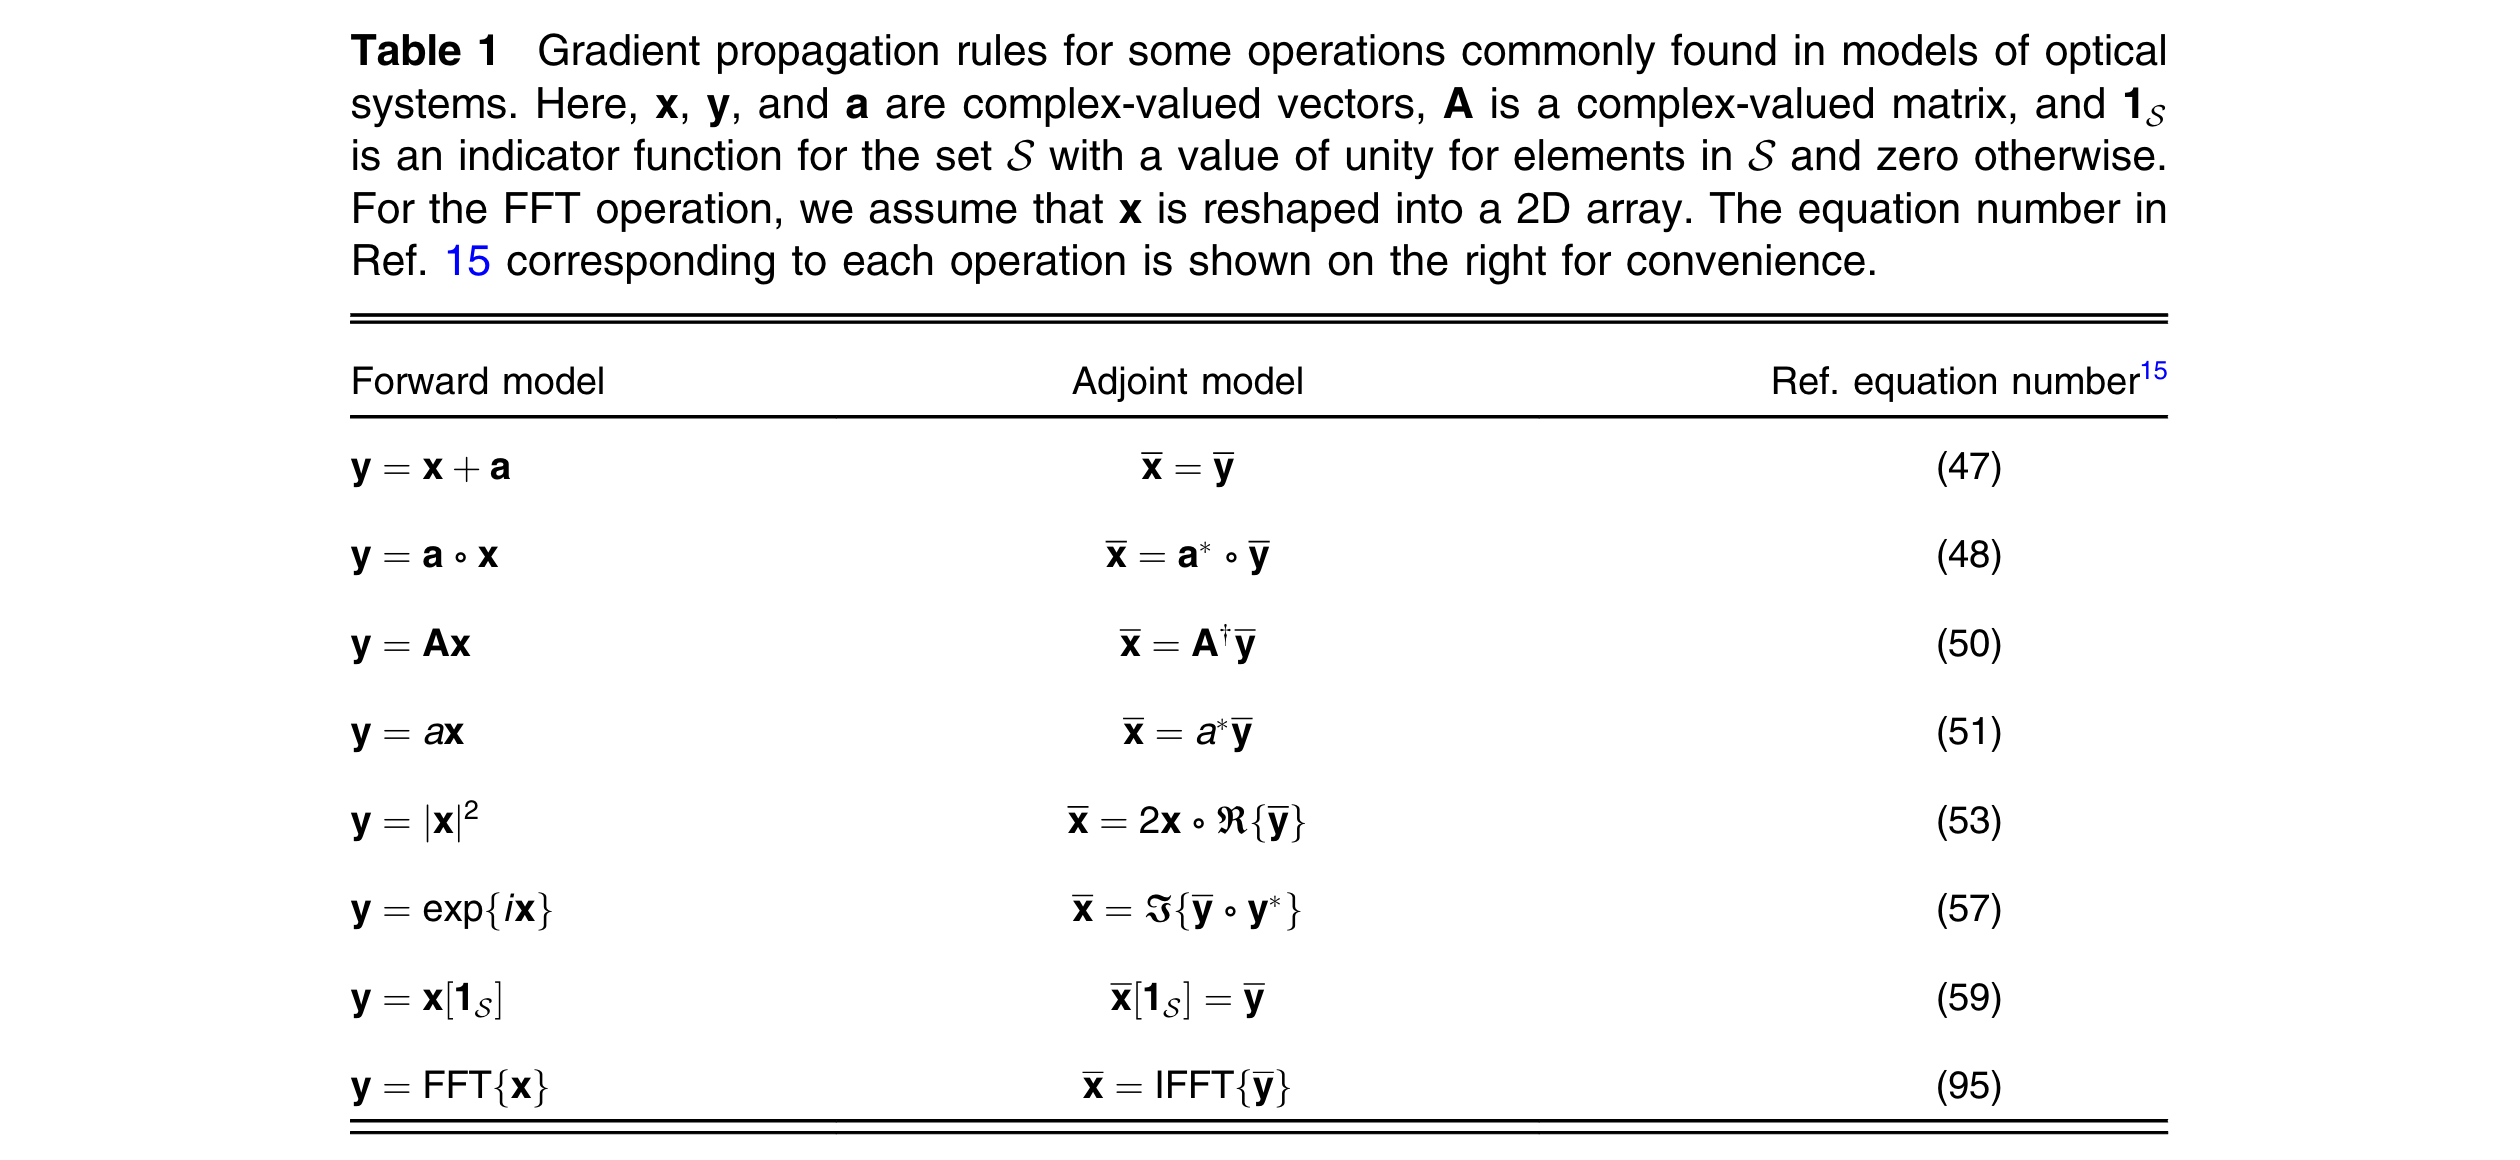

In [ ]:
# def cost_fun(del_actuators):

#     command = jdm.map_actuators_to_command(del_actuators, dm_mask)
#     delphi = jnp.angle(jdm.get_phasor(command, inf_fun, inf_sampling, inf_pixelscale=inf_pixelscale*u.m/u.pix, pixelscale=pupil_pxscl))
#     delphi = jdm.pad_or_crop(delphi, npix)

#     total = WFE[pupil] + delphi[pupil]
#     J = total.dot(total)/822.08109784

#     return J

In [43]:
def compute_cost_fun(actuators):

    s_dm = forward_dm(actuators)
    total = wfe_opd[mask] + s_dm[mask]
    J = total.dot(total)

    return J

command = xp.zeros((Nact, Nact))
J0 = compute_cost_fun(command)
print(J0)

2.4195587499999994e-10


In [ ]:
def compute_grad()

In [ ]:
res = minimize(value_and_grad_of_cost, 
               jac=True, 
               x0=del_acts0, 
               method='L-BFGS-B', 
               tol=1e-3,
               options={'disp':True},
              )